# やること

- 使う実機データを変更(tek0003ALL.csv)
- vC の波形のスイッチングノイズ部分を削って学習させる


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from src.utils.load_data import load_data, path_list
from src.utils.models import BuckConverterCell, GRUModel
from src.utils.plot_data import (
    plot_compare_tail,
    plot_iLvC,
    plot_param_learning_progress,
    plot_u_vs_iL_vC,
)

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

np.random.seed(seed)

In [2]:
keep_log = False  # 結果保存するかどうか

# 真値パラメータ
L_true: float = 223.6e-6
C_true: float = 73.8e-6
R_true: float = 5

Vin: int = 10
Vref: int = 5
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
cycles: int = 10
samples_per_cycle: int = 200

train_ratio = 0.3
valid_ratio = 0.3
# test_ratio = 1 - train_ratio - valid_ratio

clipped_k: float = 2.0

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-2
lr_C = 1e-2
lr_R = 2e-2

epochs = 1000

# GRU学習用のデータ準備（時系列データ）
seq_length = 10

gru_lr = 0.001
gru_epochs = 200


# 実機データの確認


len(t_raw)=250001
len(iL_raw)=250001
len(vC_raw)=250001


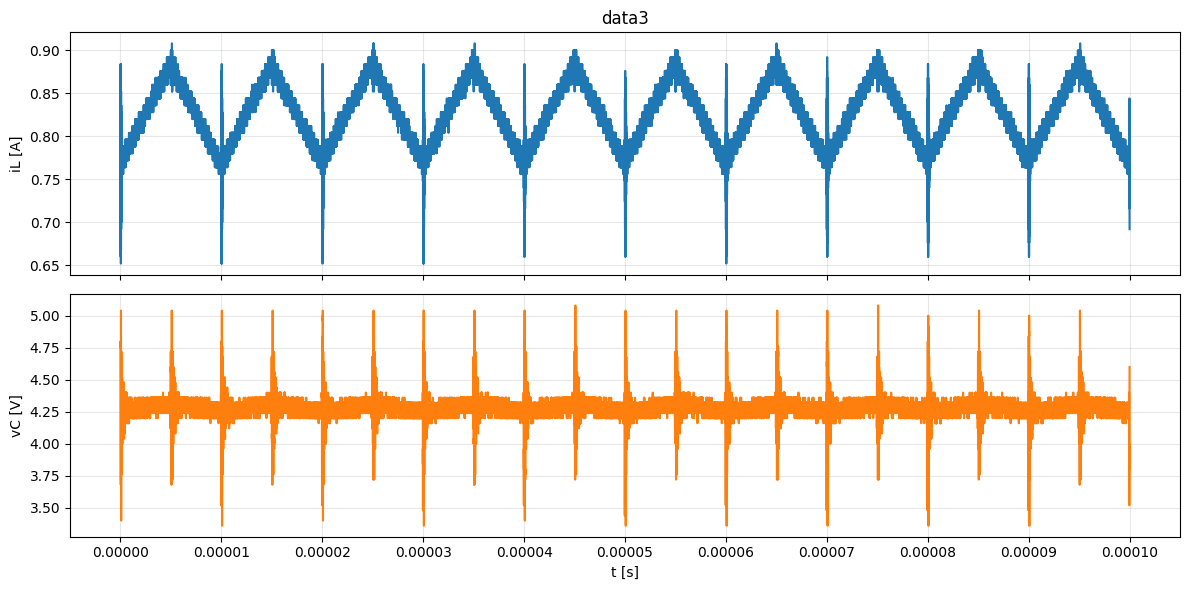

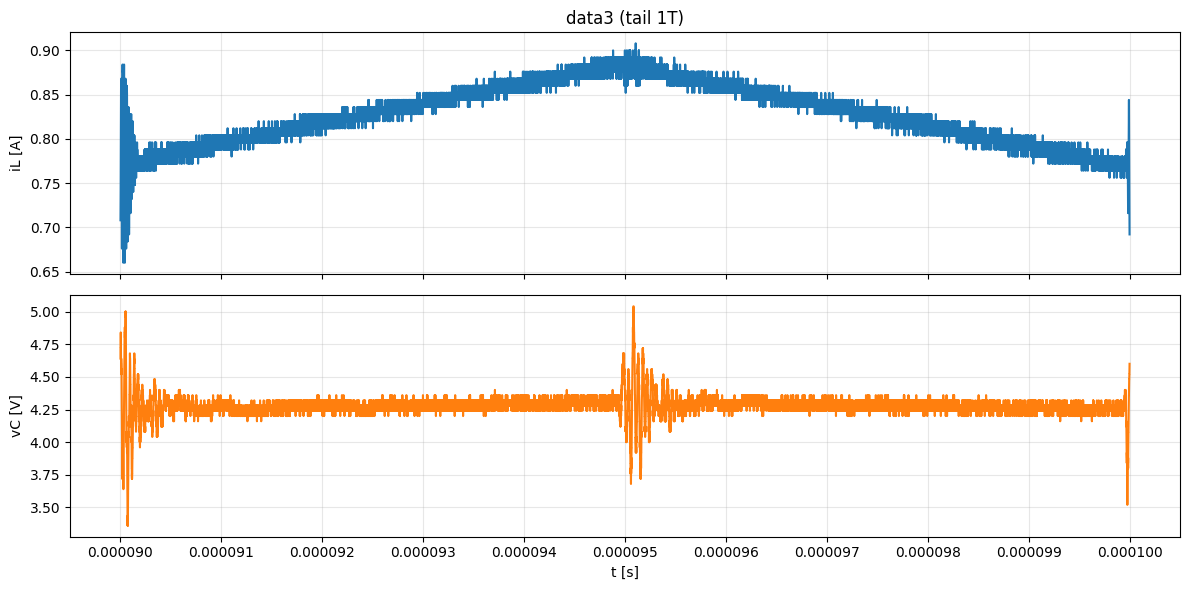

In [3]:
t_raw, iL_raw, vC_raw = load_data(
    path=path_list.path3,
    downsample_step=1,  # ダウンスケールしない
    T=T,
    cycles=cycles,
    iL_label="CH2",
    vC_label="CH1",
)

print(f"{len(t_raw)=}")
print(f"{len(iL_raw)=}")
print(f"{len(vC_raw)=}")

plot_iLvC(
    t_raw,
    iL_raw,
    vC_raw,
    T=T,
    title="data3",
    show_tail_10=False,
)
plt.show()


# 理想的なシミュレーション波形との比較


In [4]:
t_sim_true: np.ndarray = np.linspace(0, 1000 * T, 1000 * samples_per_cycle + 1)
dt_sim_true: np.ndarray = np.diff(t_sim_true)

# スイッチング信号
duty_phase = (t_sim_true[:-1] % T) / T
u_sim_true = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim_true = np.ones(len(t_sim_true) - 1) * Vin

# モデルを作成
model_true = BuckConverterCell(L_init=L_true, C_init=C_true, R_init=R_true)

# numpy配列をテンソルに変換（dtをxに含める）
x_tensor = torch.tensor(
    np.c_[vs_sim_true, u_sim_true, dt_sim_true],
    dtype=torch.float32,
)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_sim_true) - 1):
        h_current = model_true(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

iL_sim_true = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_sim_true = torch.tensor(np.array(vc_list), dtype=torch.float32)


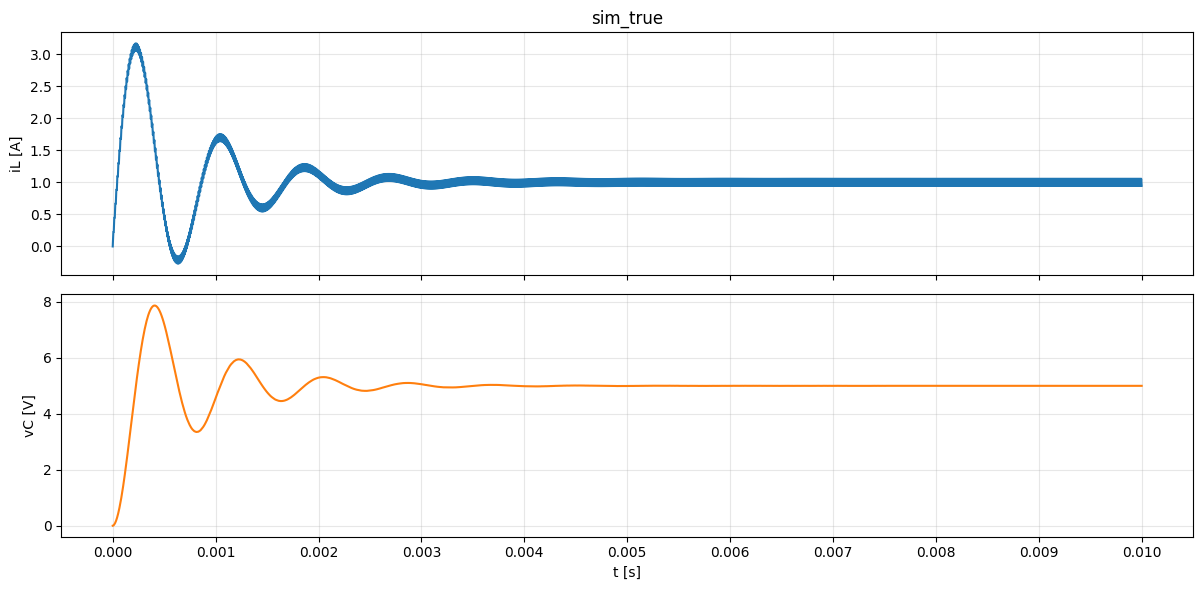

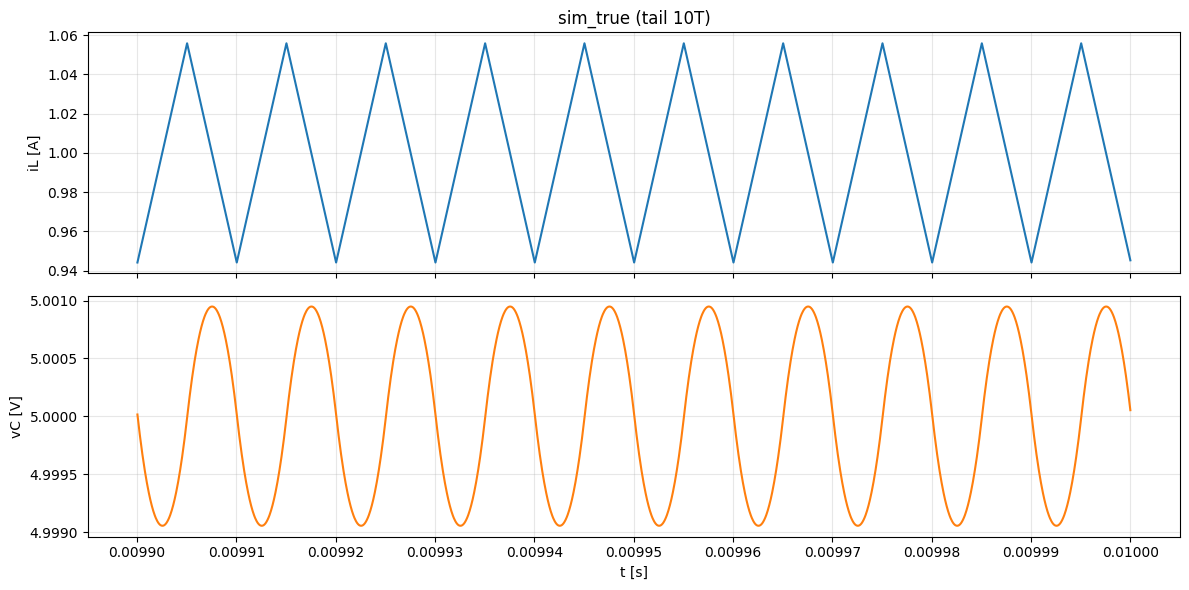

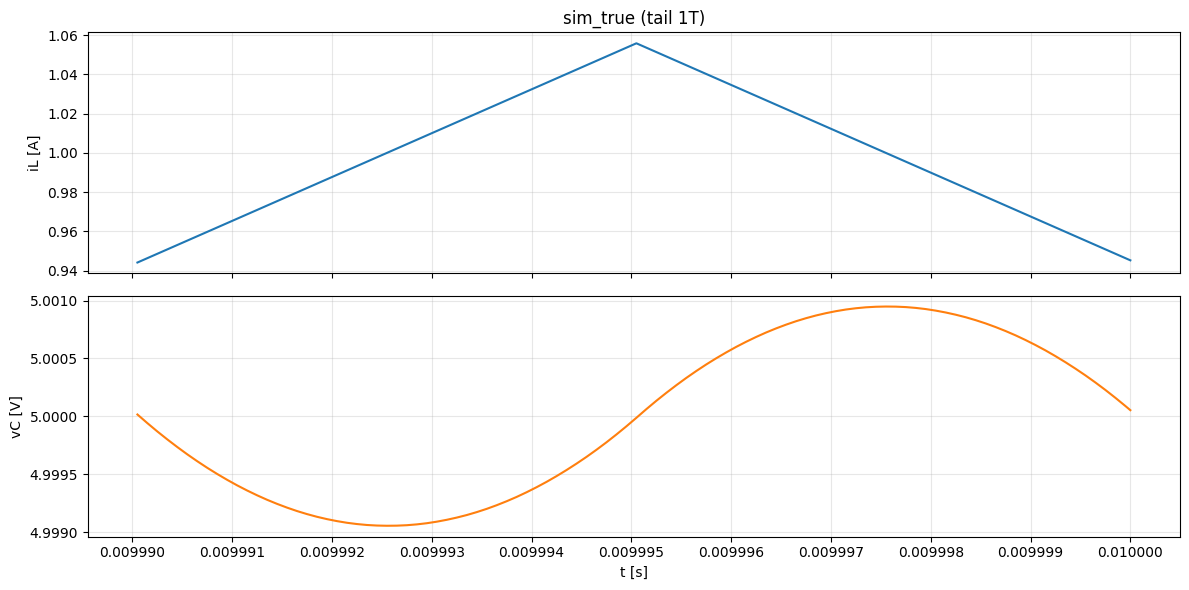

In [5]:
plot_iLvC(t_sim_true, iL_sim_true, vC_sim_true, T=T, title="sim_true")
plt.show()


(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'Comparison (Last 1 Cycle): iL (Last 1 Cycles)'}, ylabel='iL [A]'>,
        <Axes: title={'center': 'Comparison (Last 1 Cycle): vC (Last 1 Cycles)'}, xlabel='Time [μs]', ylabel='vC [V]'>],
       dtype=object))

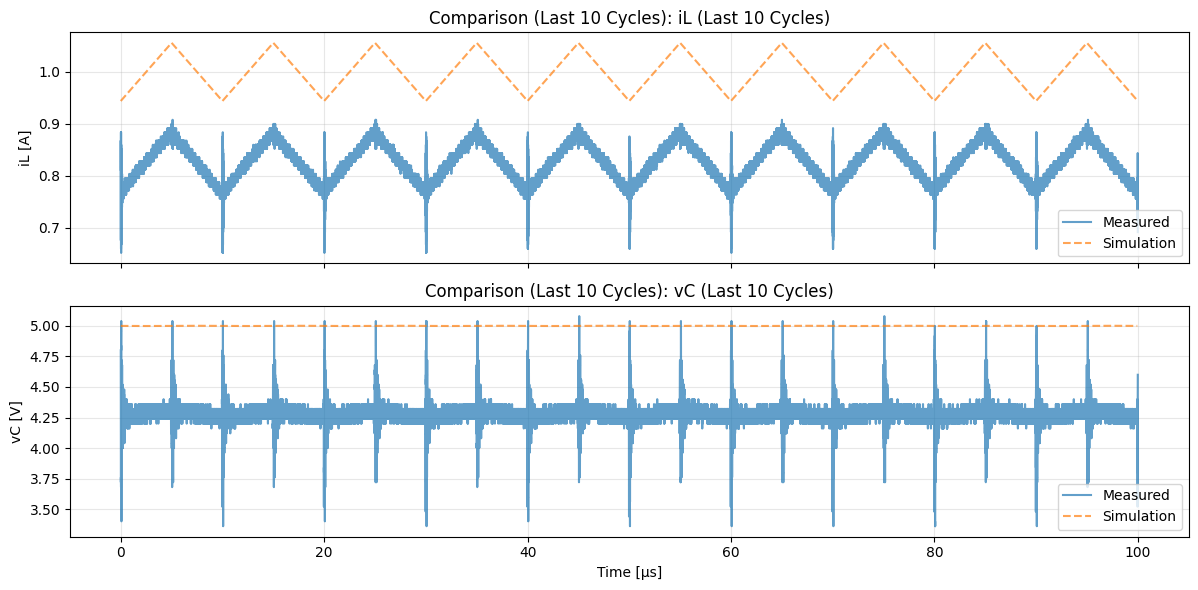

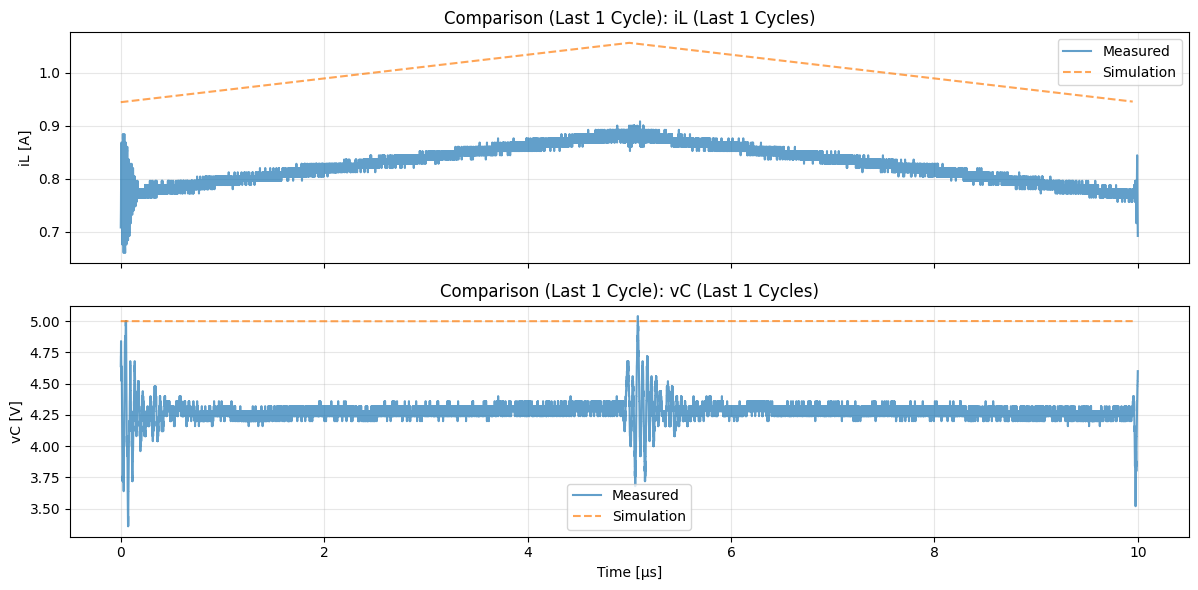

In [6]:
# --- Comparison for last 10 cycles ---
plot_compare_tail(
    t_raw,
    iL_raw,
    vC_raw,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=10,
    title="Comparison (Last 10 Cycles)",
)

# --- Comparison for last 1 cycle ---
plot_compare_tail(
    t_raw,
    iL_raw,
    vC_raw,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=1,
    title="Comparison (Last 1 Cycle)",
)


# BuckConverterCell 前処理


- サンプル数を下げる
  - 1 周期あたり 200 プロット程度
- u, vs の作成
- iL, vC のノイズをカット
  - 平均と分散から外れ値を計算して min-max でクリッピング
- train, valid, test の分割


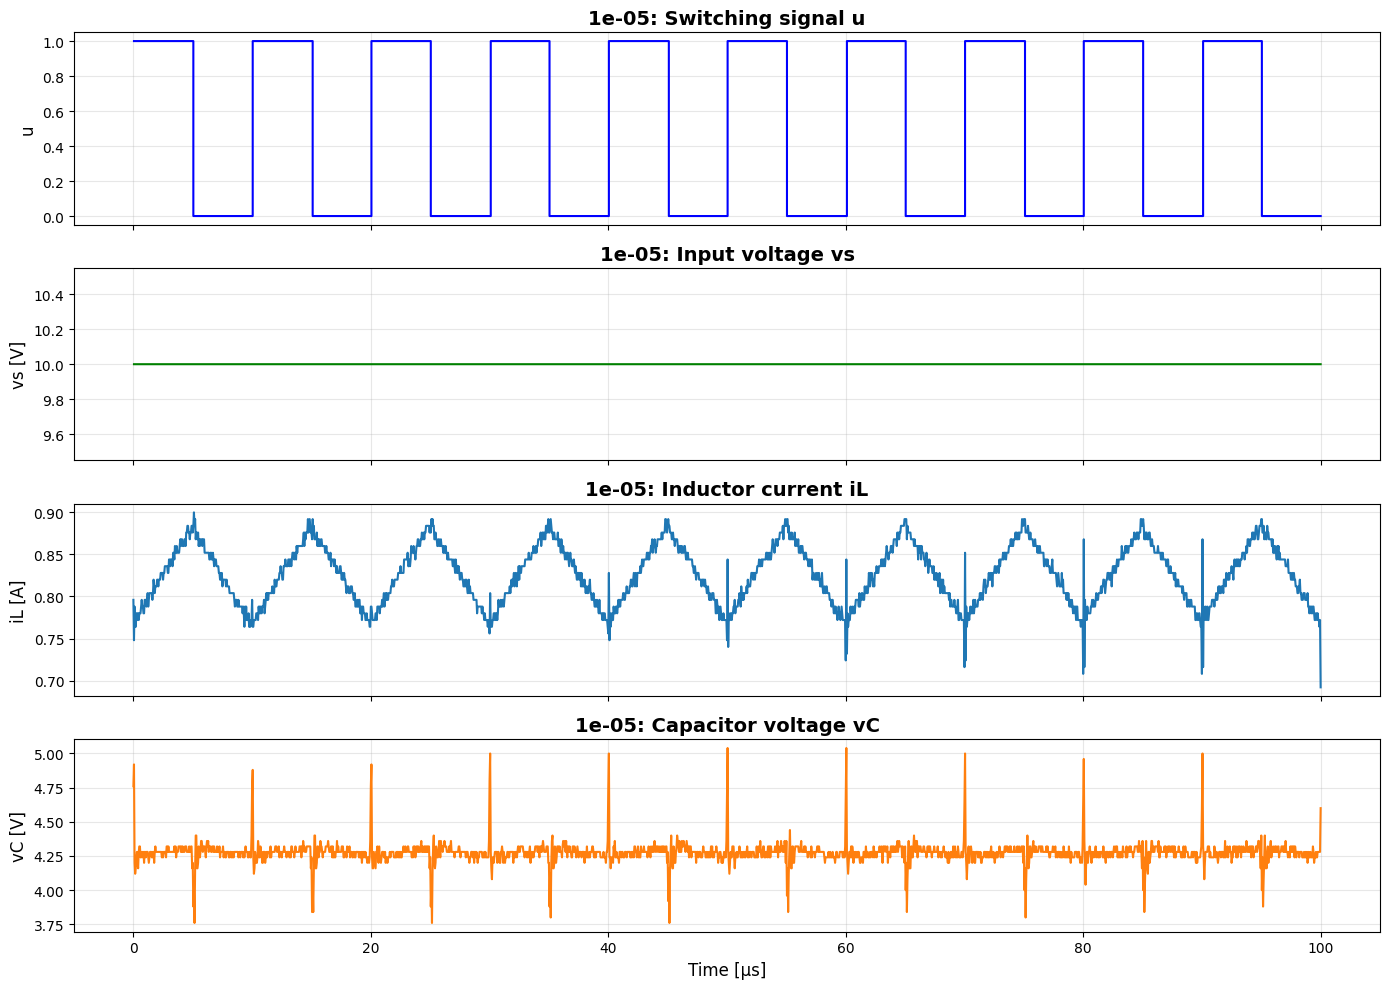

In [7]:
# サンプル数を下げる
downsample_step = len(t_raw) // (samples_per_cycle * cycles)
t_downsampled: np.ndarray = t_raw[::downsample_step]
iL_downsampled: np.ndarray = iL_raw[::downsample_step]
vC_downsampled: np.ndarray = vC_raw[::downsample_step]

# スイッチング信号
duty_phase = (t_downsampled[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_downsampled) - 1) * Vin

plot_u_vs_iL_vC(t_downsampled, u, vs, iL_downsampled, vC_downsampled, T)
plt.show()

iL clip range: 0.7576183304190636 0.8954472318291664
vC clip range: 4.106971323490143 4.442992627620697


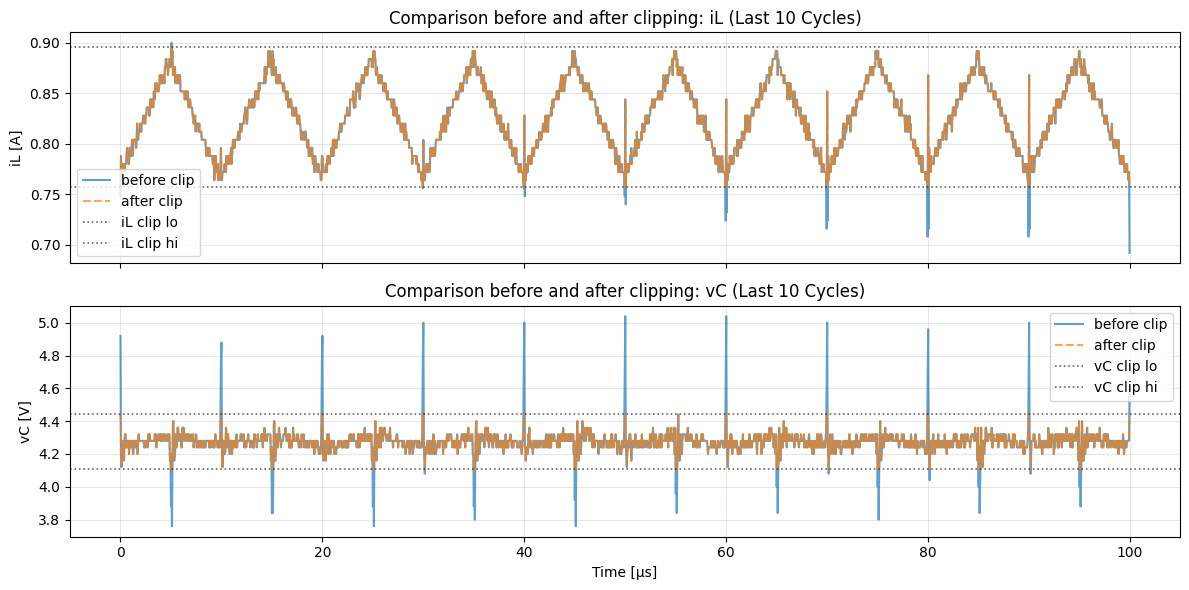

In [8]:
# ノイズのクリッピング
def clip_by_mean_std(x: np.ndarray, k: float) -> tuple[np.ndarray, float, float]:
    mu = float(np.mean(x))
    std = float(np.std(x))
    lo = mu - k * std
    hi = mu + k * std
    x_clipped = np.clip(x, lo, hi)
    return x_clipped.astype(x.dtype, copy=False), lo, hi


# クリップ
iL_clipped, iL_lo, iL_hi = clip_by_mean_std(iL_downsampled, k=clipped_k)
vC_clipped, vC_lo, vC_hi = clip_by_mean_std(vC_downsampled, k=clipped_k)
print("iL clip range:", iL_lo, iL_hi)
print("vC clip range:", vC_lo, vC_hi)

# クリップ前後の波形を比較表示
plot_compare_tail(
    t_downsampled,
    iL_downsampled,
    vC_downsampled,
    "before clip",
    t_downsampled,
    iL_clipped,
    vC_clipped,
    "after clip",
    T,
    title="Comparison before and after clipping",
    iL_range=(iL_lo, iL_hi),
    vC_range=(vC_lo, vC_hi),
)
plt.show()


In [9]:
# train, valid, test の分割
dt = t_downsampled[1:] - t_downsampled[:-1]

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)
iL_tensor = torch.tensor(iL_downsampled, dtype=torch.float32)
vC_tensor = torch.tensor(vC_downsampled, dtype=torch.float32)
iL_clipped_tensor = torch.tensor(iL_clipped, dtype=torch.float32)
vC_clipped_tensor = torch.tensor(vC_clipped, dtype=torch.float32)

# train
train_len = int(len(dt) * train_ratio)

t_train = t_downsampled[: train_len + 1]
dt_train = dt_tensor[:train_len]
u_train = u_tensor[:train_len]
vs_train = vs_tensor[:train_len]
iL_train = iL_tensor[: train_len + 1]
vC_train = vC_tensor[: train_len + 1]
iL_clipped_train = iL_clipped_tensor[: train_len + 1]
vC_clipped_train = vC_clipped_tensor[: train_len + 1]

h_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)
x_train = torch.stack([vs_train, u_train, dt_train], dim=1)
target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)

h_clipped_train = torch.stack(
    [iL_clipped_train[:-1], vC_clipped_train[:-1]],
    dim=1,
)
target_clipped_train = torch.stack(
    [iL_clipped_train[1:], vC_clipped_train[1:]],
    dim=1,
)


# valid
valid_len = int(len(dt) * valid_ratio)

t_valid = t_downsampled[train_len : train_len + valid_len]
dt_valid = dt_tensor[train_len : train_len + valid_len]
u_valid = u_tensor[train_len : train_len + valid_len]
vs_valid = vs_tensor[train_len : train_len + valid_len]
iL_valid = iL_tensor[train_len : train_len + valid_len + 1]
vC_valid = vC_tensor[train_len : train_len + valid_len + 1]
iL_clipped_valid = iL_clipped_tensor[train_len : train_len + valid_len + 1]
vC_clipped_valid = vC_clipped_tensor[train_len : train_len + valid_len + 1]

h_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
x_valid = torch.stack([vs_valid, u_valid, dt_valid], dim=1)
target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

h_clipped_valid = torch.stack(
    [iL_clipped_valid[:-1], vC_clipped_valid[:-1]],
    dim=1,
)
target_clipped_valid = torch.stack(
    [iL_clipped_valid[1:], vC_clipped_valid[1:]],
    dim=1,
)

# test
t_test = t_downsampled[train_len + valid_len :]
dt_test = dt_tensor[train_len + valid_len :]
u_test = u_tensor[train_len + valid_len :]
vs_test = vs_tensor[train_len + valid_len :]
iL_test = iL_tensor[train_len + valid_len :]
vC_test = vC_tensor[train_len + valid_len :]
iL_clipped_test = iL_clipped_tensor[train_len + valid_len :]
vC_clipped_test = vC_clipped_tensor[train_len + valid_len :]

h_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
x_test = torch.stack([vs_test, u_test, dt_test], dim=1)
target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)

h_clipped_test = torch.stack(
    [iL_clipped_test[:-1], vC_clipped_test[:-1]],
    dim=1,
)
target_clipped_test = torch.stack(
    [iL_clipped_test[1:], vC_clipped_test[1:]],
    dim=1,
)

print(f"{h_train.shape=}")
print(f"{x_train.shape=}")
print(f"{target_train.shape=}")

print(f"{h_valid.shape=}")
print(f"{x_valid.shape=}")
print(f"{target_valid.shape=}")

print(f"{h_test.shape=}")
print(f"{x_test.shape=}")
print(f"{target_test.shape=}")


h_train.shape=torch.Size([600, 2])
x_train.shape=torch.Size([600, 3])
target_train.shape=torch.Size([600, 2])
h_valid.shape=torch.Size([600, 2])
x_valid.shape=torch.Size([600, 3])
target_valid.shape=torch.Size([600, 2])
h_test.shape=torch.Size([800, 2])
x_test.shape=torch.Size([800, 3])
target_test.shape=torch.Size([800, 2])


# BuckConverterCell の学習


In [10]:
buck_converter_cell = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [buck_converter_cell.log_L], "lr": lr_L},
        {"params": [buck_converter_cell.log_C], "lr": lr_C},
        {"params": [buck_converter_cell.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    buck_converter_cell.train()
    optimizer.zero_grad()
    h_pred_train = buck_converter_cell(h_clipped_train, x_train)
    train_loss = loss_fn(h_pred_train, target_clipped_train)
    train_loss.backward()
    optimizer.step()

    loss_history["train"].append(train_loss.item())

    # 検証モード（勾配計算なし）
    buck_converter_cell.eval()
    with torch.no_grad():
        h_pred_valid = buck_converter_cell(h_clipped_valid, x_valid)
        valid_loss = loss_fn(h_pred_valid, target_clipped_valid)
        loss_history["valid"].append(valid_loss.item())

    # パラメータの履歴を保存
    param_history["L"].append(buck_converter_cell.log_L.exp().item())
    param_history["C"].append(buck_converter_cell.log_C.exp().item())
    param_history["R"].append(buck_converter_cell.log_R.exp().item())

    if epoch % 50 == 0:
        output_line = (
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}\n"
            f"  L={buck_converter_cell.log_L.exp().item() * 1e6:.1f}µH "
            f"(true={L_true * 1e6:.1f})"
            f"C={buck_converter_cell.log_C.exp().item() * 1e6:.1f}µF "
            f"(true={C_true * 1e6:.1f})"
            f"R={buck_converter_cell.log_R.exp().item():.2f}Ω "
            f"(true={R_true:.1f})"
        )
        print(output_line)

# テストデータでの評価
buck_converter_cell.eval()
with torch.no_grad():
    h_pred_test = buck_converter_cell(h_clipped_test, x_test)
    test_loss = loss_fn(h_pred_test, target_clipped_test)

print(f"Final test loss: {test_loss.item():.6e}")


Epoch 0: Train Loss=1.326861e-03, Valid Loss=1.427876e-03
  L=210.0µH (true=223.6)C=99.1µF (true=73.8)R=7.85Ω (true=5.0)
Epoch 50: Train Loss=1.326602e-03, Valid Loss=1.427715e-03
  L=289.9µH (true=223.6)C=58.8µF (true=73.8)R=3.38Ω (true=5.0)
Epoch 100: Train Loss=1.326417e-03, Valid Loss=1.427555e-03
  L=288.7µH (true=223.6)C=31.5µF (true=73.8)R=4.19Ω (true=5.0)
Epoch 150: Train Loss=1.325933e-03, Valid Loss=1.427140e-03
  L=288.9µH (true=223.6)C=14.1µF (true=73.8)R=4.69Ω (true=5.0)
Epoch 200: Train Loss=1.324442e-03, Valid Loss=1.425856e-03
  L=288.8µH (true=223.6)C=5.1µF (true=73.8)R=4.99Ω (true=5.0)
Epoch 250: Train Loss=1.319297e-03, Valid Loss=1.421491e-03
  L=288.8µH (true=223.6)C=1.5µF (true=73.8)R=5.13Ω (true=5.0)
Epoch 300: Train Loss=1.304840e-03, Valid Loss=1.410304e-03
  L=288.8µH (true=223.6)C=0.4µF (true=73.8)R=5.16Ω (true=5.0)
Epoch 350: Train Loss=1.298850e-03, Valid Loss=1.408835e-03
  L=288.8µH (true=223.6)C=0.2µF (true=73.8)R=5.17Ω (true=5.0)
Epoch 400: Train Loss=1

# GRU 前処理


In [11]:
# 前処理
t_sim: np.ndarray = np.linspace(0, 1000 * T, 1000 * samples_per_cycle + 1)

t_additional = t_downsampled + t_sim[-1]
t_sim = np.concatenate([t_sim, t_additional])


dt_sim: np.ndarray = np.diff(t_sim)

# スイッチング信号
duty_phase = (t_sim[:-1] % T) / T
u_sim = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_sim) - 1) * Vin

x_tensor = torch.tensor(np.c_[vs_sim, u_sim, dt_sim], dtype=torch.float32)

h_sim = [torch.zeros(1, 2)]

# シミュレーション実行
with torch.no_grad():
    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_sim[-1], x_tensor[j : j + 1])
        h_sim.append(h_current)


def create_sequences(
    h_data: torch.Tensor,
    x_data: torch.Tensor,
    noise_data: torch.Tensor,
    seq_len: int,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    時系列データを作成
    入力: [iL, vC, vs, u, dt, iL_noise, vC_noise]
    出力: [iL_noise, vC_noise]
    """
    sequences = []
    targets = []

    for i in range(len(h_data) - seq_len):
        # 入力特徴量: [iL, vC, vs, u, dt] + 過去のノイズ [iL_noise, vC_noise]
        seq_input = []
        for j in range(seq_len):
            idx = i + j
            # 状態と入力
            features = torch.cat(
                [
                    h_data[idx],  # [iL, vC]
                    x_data[idx],  # [vs, u, dt]
                ]
            )
            # 過去のノイズ（存在する場合）
            if idx > 0:
                noise_features = noise_data[idx - 1]  # [iL_noise, vC_noise]
            else:
                noise_features = torch.zeros(2)
            # 結合: [iL, vC, vs, u, dt, iL_noise, vC_noise] = 7次元
            combined = torch.cat([features, noise_features])
            seq_input.append(combined)

        sequences.append(torch.stack(seq_input))
        targets.append(noise_data[i + seq_len])

    return torch.stack(sequences), torch.stack(targets)


# リスト -> テンソルに変換して、実測 - シミュレーションをノイズとして計算
h_sim_tensor = torch.cat(h_sim, dim=0)
h_sim_tensor = h_sim_tensor[1000 * samples_per_cycle + 1 :]
# 学習で使っている h_* は「1ステップ前の状態」(N-1)なので、シミュレーションも揃える
h_sim_tensor = h_sim_tensor[:-1]

h_meas_tensor = torch.stack([iL_tensor[:-1], vC_tensor[:-1]], dim=1)

n = min(h_meas_tensor.shape[0], h_sim_tensor.shape[0])
h_noise = h_meas_tensor[:n] - h_sim_tensor[:n]

# データセットを作成
X_train_seq, y_train_seq = create_sequences(
    h_train, x_train, h_noise[: len(h_train)], seq_length
)
X_valid_seq, y_valid_seq = create_sequences(
    h_valid, x_valid, h_noise[len(h_train) : len(h_train) + len(h_valid)], seq_length
)
X_test_seq, y_test_seq = create_sequences(
    h_test, x_test, h_noise[len(h_train) + len(h_valid) :], seq_length
)

print(f"学習データ: {X_train_seq.shape} -> {y_train_seq.shape}")
print(f"検証データ: {X_valid_seq.shape} -> {y_valid_seq.shape}")
print(f"テストデータ: {X_test_seq.shape} -> {y_test_seq.shape}")
print(
    f"入力特徴量の次元: {X_train_seq.shape[2]} (iL, vC, vs, u, dt, iL_noise, vC_noise)"
)

学習データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
検証データ: torch.Size([590, 10, 7]) -> torch.Size([590, 2])
テストデータ: torch.Size([790, 10, 7]) -> torch.Size([790, 2])
入力特徴量の次元: 7 (iL, vC, vs, u, dt, iL_noise, vC_noise)


# GRU の学習


In [12]:
# 学習
gru_model = GRUModel(
    input_size=X_train_seq.shape[2],
    hidden_size=32,
    num_layers=2,
    output_size=2,
    seq_length=seq_length,
)


gru_optimizer = optim.Adam(gru_model.parameters(), lr=gru_lr)
gru_loss_fn = nn.MSELoss()

gru_loss_history = {"train": [], "valid": []}

for epoch in range(gru_epochs):
    # 学習モード
    gru_model.train()
    gru_optimizer.zero_grad()
    noise_pred_train = gru_model(X_train_seq)
    train_loss = gru_loss_fn(noise_pred_train, y_train_seq)
    train_loss.backward()
    gru_optimizer.step()

    gru_loss_history["train"].append(train_loss.item())

    # 検証モード
    gru_model.eval()
    with torch.no_grad():
        noise_pred_valid = gru_model(X_valid_seq)
        valid_loss = gru_loss_fn(noise_pred_valid, y_valid_seq)
        gru_loss_history["valid"].append(valid_loss.item())

    if (epoch + 1) % 50 == 0:
        print(
            f"Epoch {epoch + 1}/{gru_epochs}: "
            f"Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}"
        )


Epoch 50/200: Train Loss=8.563765e-03, Valid Loss=8.733732e-03
Epoch 100/200: Train Loss=7.328177e-03, Valid Loss=7.328173e-03
Epoch 150/200: Train Loss=6.727856e-03, Valid Loss=6.708929e-03
Epoch 200/200: Train Loss=6.119434e-03, Valid Loss=6.093130e-03


# 結果


In [13]:
import sys

sys.path.append("../..")


from src.utils.save_log import (
    create_result_dir,
    init_log,
    save_figure_to_log,
    save_text_output,
)

config_dict = {
    "file_name": "note2",
    "L_true": L_true,
    "C_true": C_true,
    "R_true": R_true,
    "Vin": Vin,
    "Vref": Vref,
    "duty": duty,
    "f_sw": f_sw,
    "T": T,
    "train_ratio": train_ratio,
    "valid_ratio": valid_ratio,
    "L_init": L_init,
    "C_init": C_init,
    "R_init": R_init,
    "lr_L": lr_L,
    "lr_C": lr_C,
    "lr_R": lr_R,
    "epochs": epochs,
    "seq_length": seq_length,
    "gru_lr": gru_lr,
    "gru_epochs": gru_epochs,
}

# ログ保存の初期化
if keep_log:
    result_dir = create_result_dir(
        "note1",
        base_dir="results/actual",
        config_dict=config_dict,
    )
    log_path = init_log(result_dir, "actual_machine_notebooks/note1/note1.ipynb")

In [14]:
final_train_loss = loss_history["train"][-1]
final_valid_loss = loss_history["valid"][-1]
final_test_loss = test_loss.item()

final_L = param_history["L"][-1]
final_C = param_history["C"][-1]
final_R = param_history["R"][-1]

# 実験設定の表示
result_text = []
result_text.append("=== Buck Converter Cell ===")
result_text.append("")
result_text.append("【回路パラメータ】")
result_text.append(
    f"  真の値: L = {L_true:.6e} [H], C = {C_true:.6e} [F], R = {R_true:.3f} [Ω]"
)
result_text.append(
    f"  初期値: L = {L_init:.6e} [H], C = {C_init:.6e} [F], R = {R_init:.3f} [Ω]"
)
result_text.append(
    f"  推論値: L = {final_L:.6e} [H], C = {final_C:.6e} [F], R = {final_R:.3f} [Ω]"
)
result_text.append("")
result_text.append("【入力条件】")
result_text.append(
    f"  Vin (入力電圧) = {Vin:.2f} [V], Vref (目標電圧) = {Vref:.2f} [V]"
)
result_text.append(f"  スイッチング周波数 f_sw = {f_sw:.0f} [Hz]")
result_text.append(f"  1周期あたりのプロット数 = {samples_per_cycle}")
result_text.append("")
result_text.append("【データ分割】")
result_text.append(
    f"  シミュレーション時間: {cycles}周期 = "
    + f"{(t_downsampled[-1] - t_downsampled[0]) * 1e6:.1f}μs"
)
result_text.append(f"  学習データ: {train_len} ステップ")
result_text.append(f"  検証データ: {valid_len} ステップ")
result_text.append(
    f"  テストデータ: {len(t_downsampled) - train_len - valid_len} ステップ"
)
result_text.append("")
result_text.append("【最終Loss】")
result_text.append(f"  学習データ: {final_train_loss:.6e}")
result_text.append(f"  検証データ: {final_valid_loss:.6e}")
result_text.append(f"  テストデータ: {final_test_loss:.6e}")
result_text.append("")
result_text.append("【学習設定】")
result_text.append(f"  エポック数: {epochs}")
result_text.append(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")

result_text.append("=== GRU ===")
result_text.append(f"  エポック数: {gru_epochs}")
result_text.append(f"  学習率: {gru_lr:.2e}")
result_text.append(f"  シーケンス長: {seq_length}")

result_output = "\n".join(result_text)
print(result_output)

# 結果をログに保存
if keep_log:
    save_text_output(result_dir, result_output, "最終結果")


=== Buck Converter Cell ===

【回路パラメータ】
  真の値: L = 2.236000e-04 [H], C = 7.380000e-05 [F], R = 5.000 [Ω]
  初期値: L = 2.000000e-04 [H], C = 1.000000e-04 [F], R = 8.000 [Ω]
  推論値: L = 2.888266e-04 [H], C = 2.263890e-07 [F], R = 5.170 [Ω]

【入力条件】
  Vin (入力電圧) = 10.00 [V], Vref (目標電圧) = 5.00 [V]
  スイッチング周波数 f_sw = 100000 [Hz]
  1周期あたりのプロット数 = 200

【データ分割】
  シミュレーション時間: 10周期 = 100.0μs
  学習データ: 600 ステップ
  検証データ: 600 ステップ
  テストデータ: 801 ステップ

【最終Loss】
  学習データ: 1.298792e-03
  検証データ: 1.408500e-03
  テストデータ: 1.627007e-03

【学習設定】
  エポック数: 1000
  学習率: L = 5.00e-02, C = 1.00e-02, R = 2.00e-02
=== GRU ===
  エポック数: 200
  学習率: 1.00e-03
  シーケンス長: 10


# BuckConverterCell


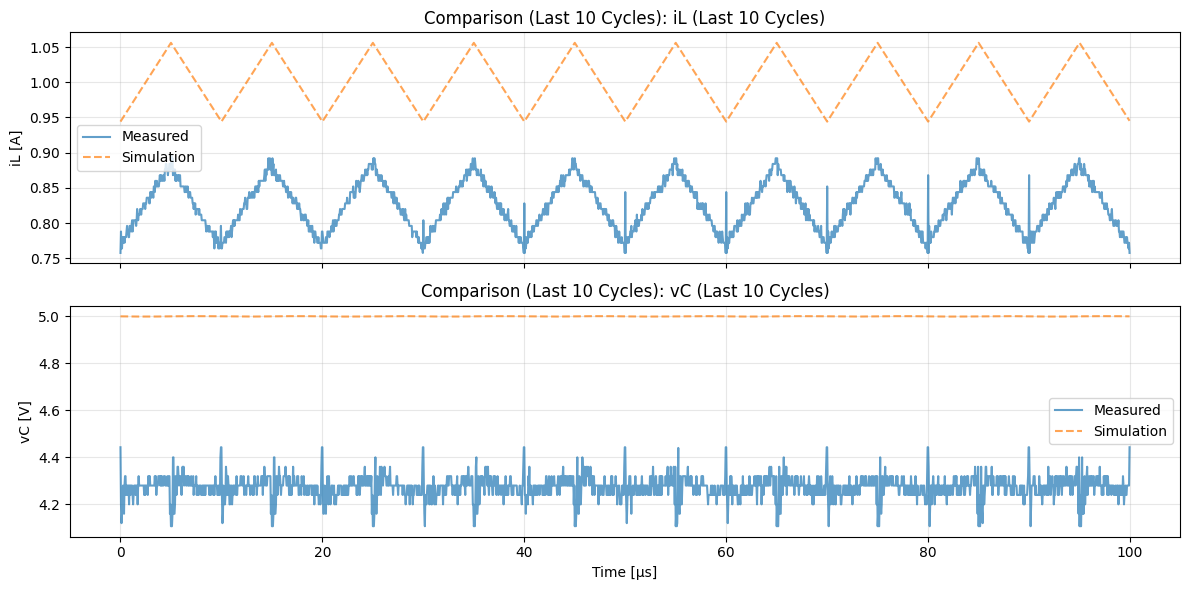

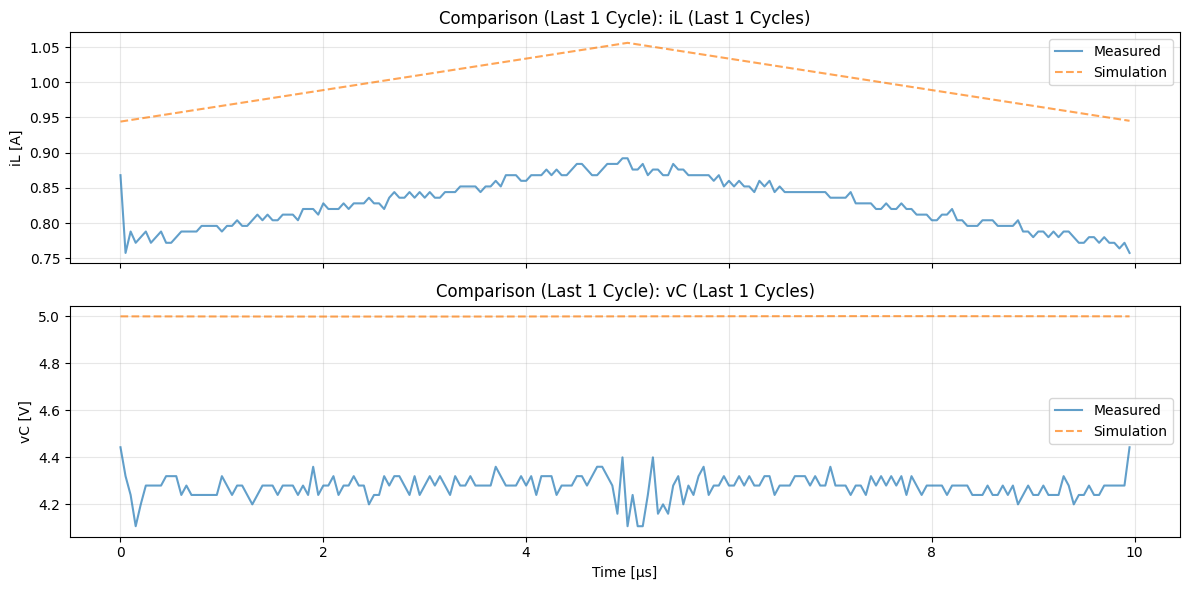

In [15]:
# --- Comparison for last 10 cycles ---
fig, ax = plot_compare_tail(
    t_downsampled,
    iL_clipped,
    vC_clipped,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=10,
    title="Comparison (Last 10 Cycles)",
)

if keep_log:
    save_figure_to_log(
        fig,
        "true_circuit_sim_and_measured",
        result_dir,
        "真の回路シミュレーション & 実測値比較(10周期分)",
    )

# --- Comparison for last 1 cycle ---
fig, ax = plot_compare_tail(
    t_downsampled,
    iL_clipped,
    vC_clipped,
    "Measured",
    t_sim_true,
    iL_sim_true,
    vC_sim_true,
    "Simulation",
    T,
    N_cycles=1,
    title="Comparison (Last 1 Cycle)",
)

if keep_log:
    save_figure_to_log(
        fig,
        "true_circuit_sim_and_measured",
        result_dir,
        "真の回路シミュレーション & 実測値比較(1周期分)",
    )


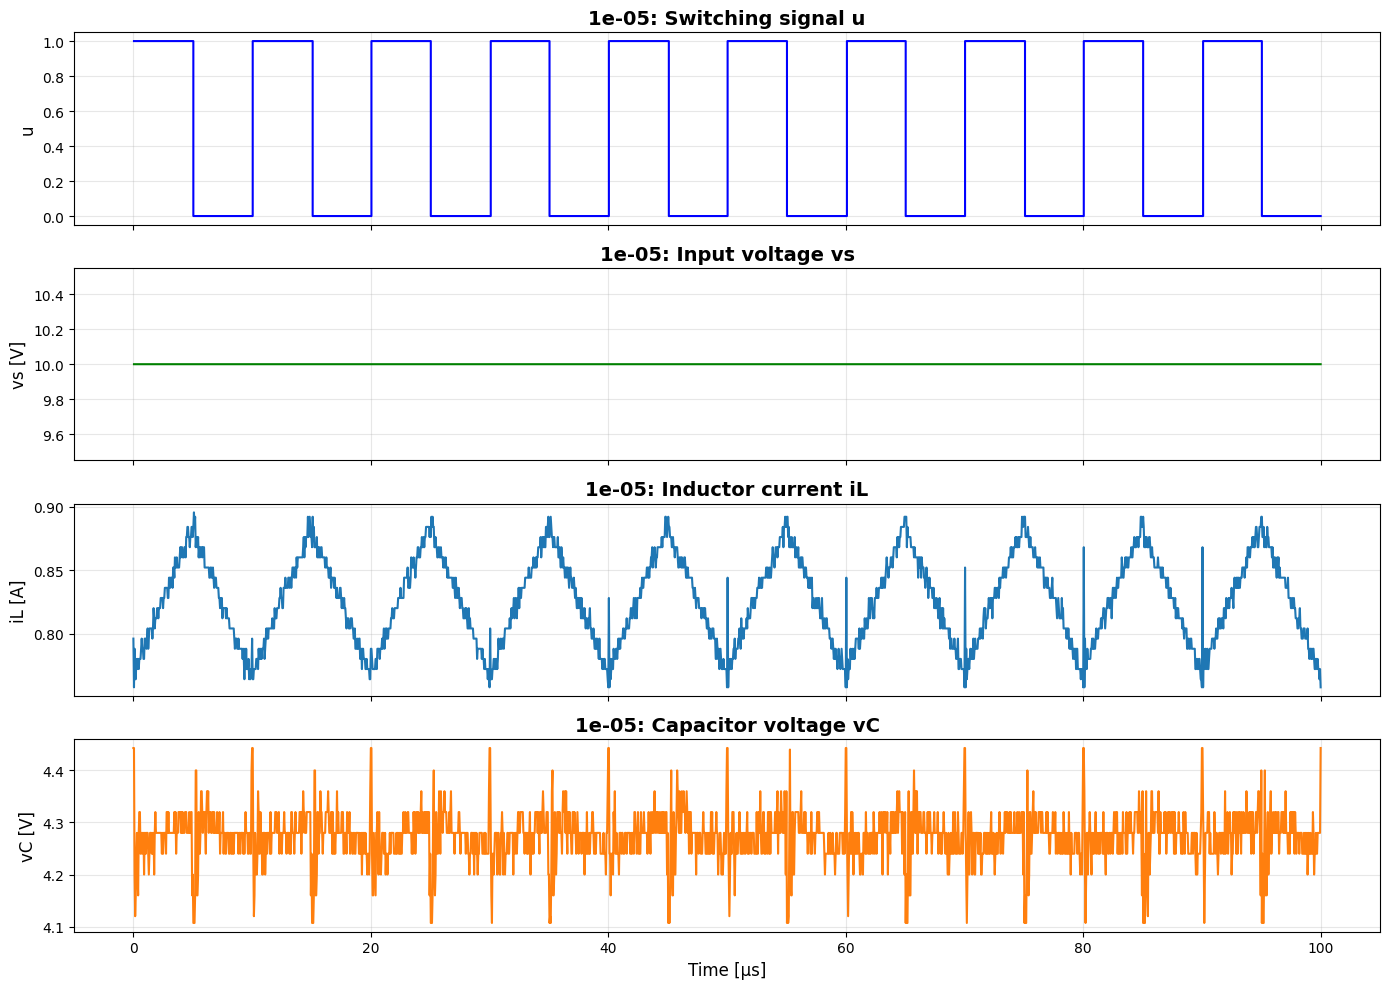

In [16]:
# 学習に使ったデータ
fig, ax = plot_u_vs_iL_vC(t_downsampled, u, vs, iL_clipped, vC_clipped, T)

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "training_data", result_dir, "学習データ")


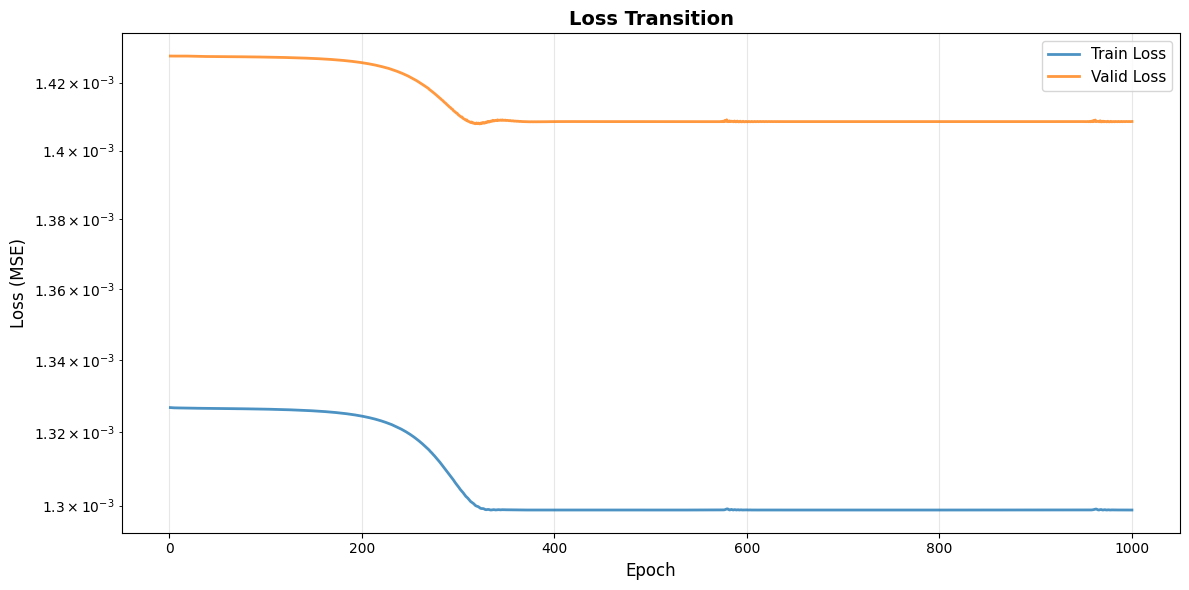

In [17]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "loss_transition", result_dir, "Lossの遷移")


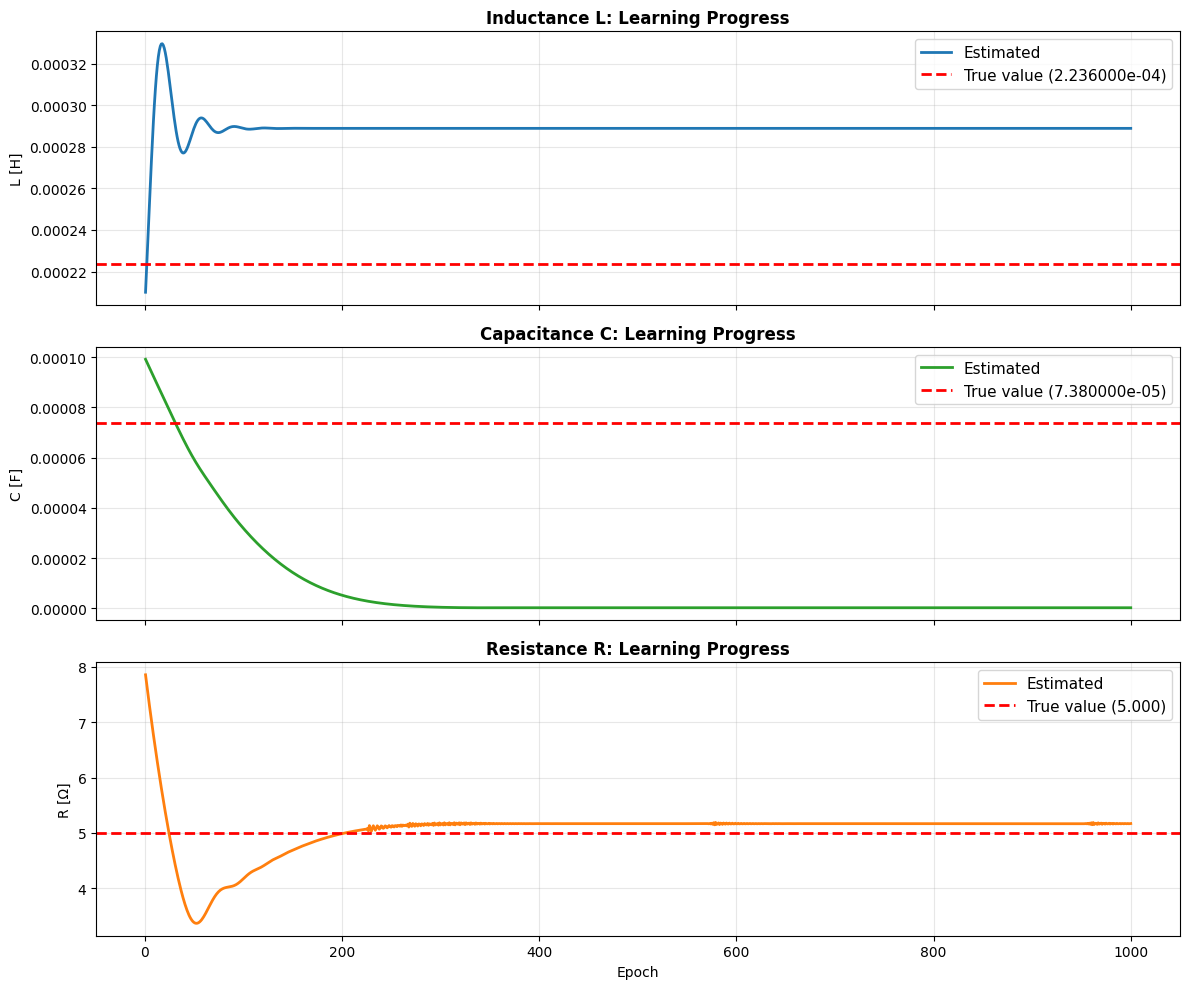

In [18]:
# 回路パラメータの学習による変化をグラフ表示
fig, ax = plot_param_learning_progress(param_history, L_true, C_true, R_true, epochs)
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig, "parameter_learning", result_dir, "回路パラメータの学習による変化"
    )


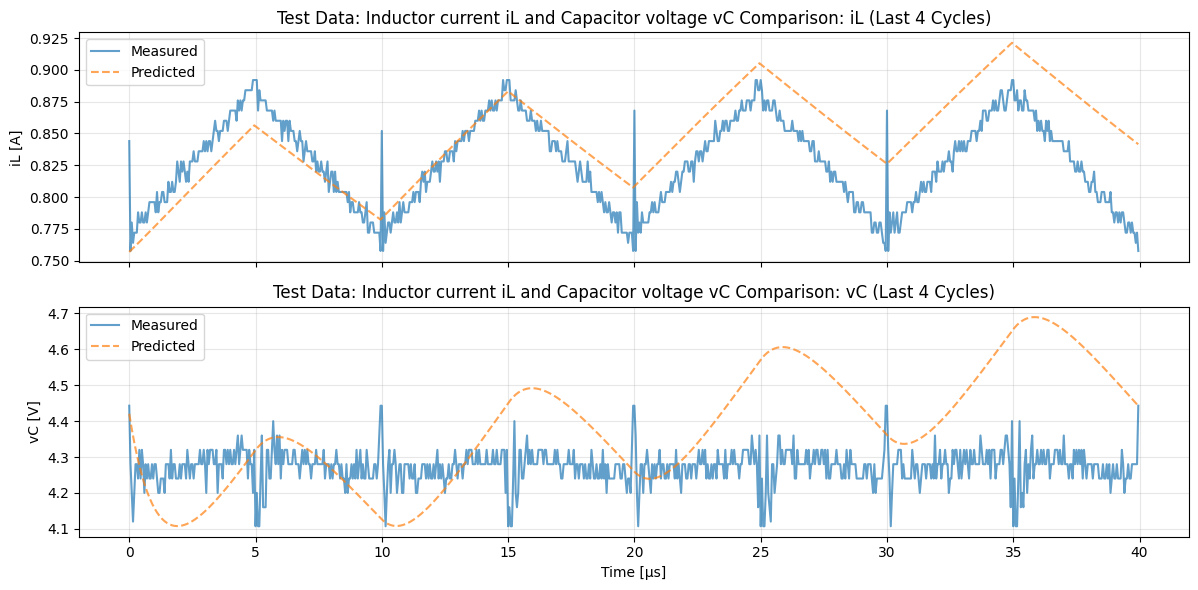

In [19]:
# テストデータでの予測結果を取得
il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = h_clipped_test[0].unsqueeze(0)
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_test) - 1):
        h_current = buck_converter_cell(h_current, x_test[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_test_pred = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_test_pred = torch.tensor(np.array(vc_list), dtype=torch.float32)


fig, ax = plot_compare_tail(
    t_test,
    iL_clipped_test,
    vC_clipped_test,
    "Measured",
    t_test,
    iL_test_pred,
    vC_test_pred,
    "Predicted",
    T,
    N_cycles=4,
    title="Test Data: Inductor current iL and Capacitor voltage vC Comparison",
)

# 画像をログに保存
if keep_log:
    save_figure_to_log(
        fig,
        "test_prediction",
        result_dir,
        "テストデータでのシミュレーション(初期値をテストデータの0番データを使用)",
    )


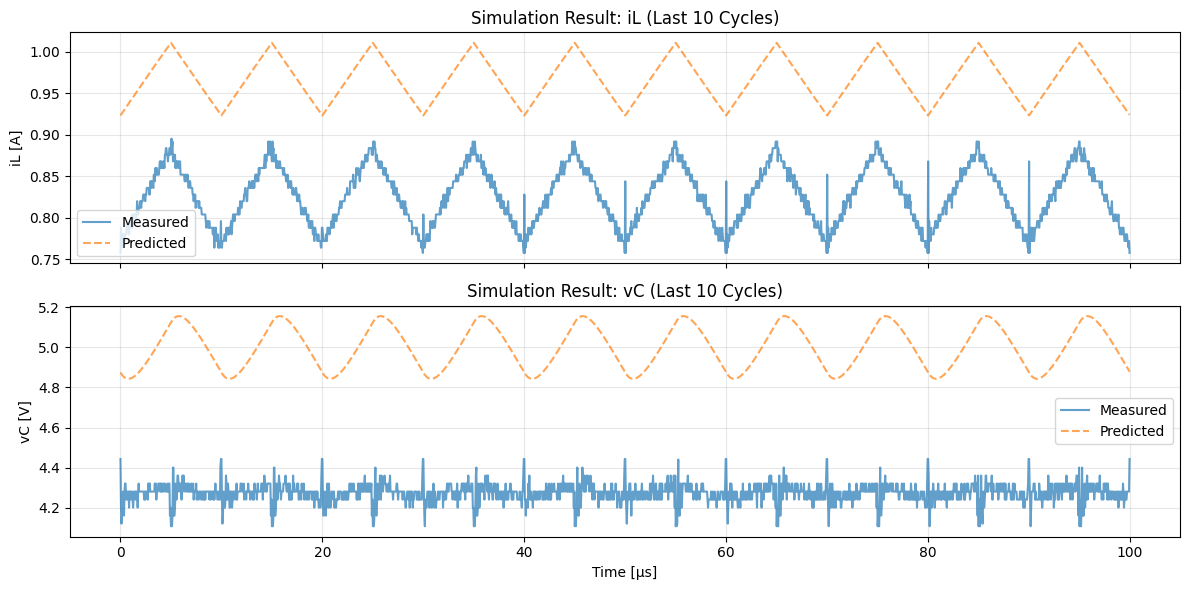

In [20]:
t_sim: np.ndarray = np.linspace(0, 1000 * T, 1000 * samples_per_cycle + 1)

dt: np.ndarray = np.diff(t_sim)

# スイッチング信号
duty_phase = (t_sim[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t_sim) - 1) * Vin

x_tensor = torch.tensor(np.c_[vs, u, dt], dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C


iL_sim = torch.tensor(np.array(il_list), dtype=torch.float32)
vC_sim = torch.tensor(np.array(vc_list), dtype=torch.float32)


# グラフ表示
fig, ax = plot_compare_tail(
    t_downsampled,
    iL_clipped,
    vC_clipped,
    "Measured",
    t_sim,
    iL_sim,
    vC_sim,
    "Predicted",
    T=T,
    title="Simulation Result",
)


if keep_log:
    save_figure_to_log(
        fig,
        "all_prediction",
        result_dir,
        "シミュレーション結果(0から1000周期までシミュレーションし、定常箇所と実機のデータの比較)",
    )


# GRU


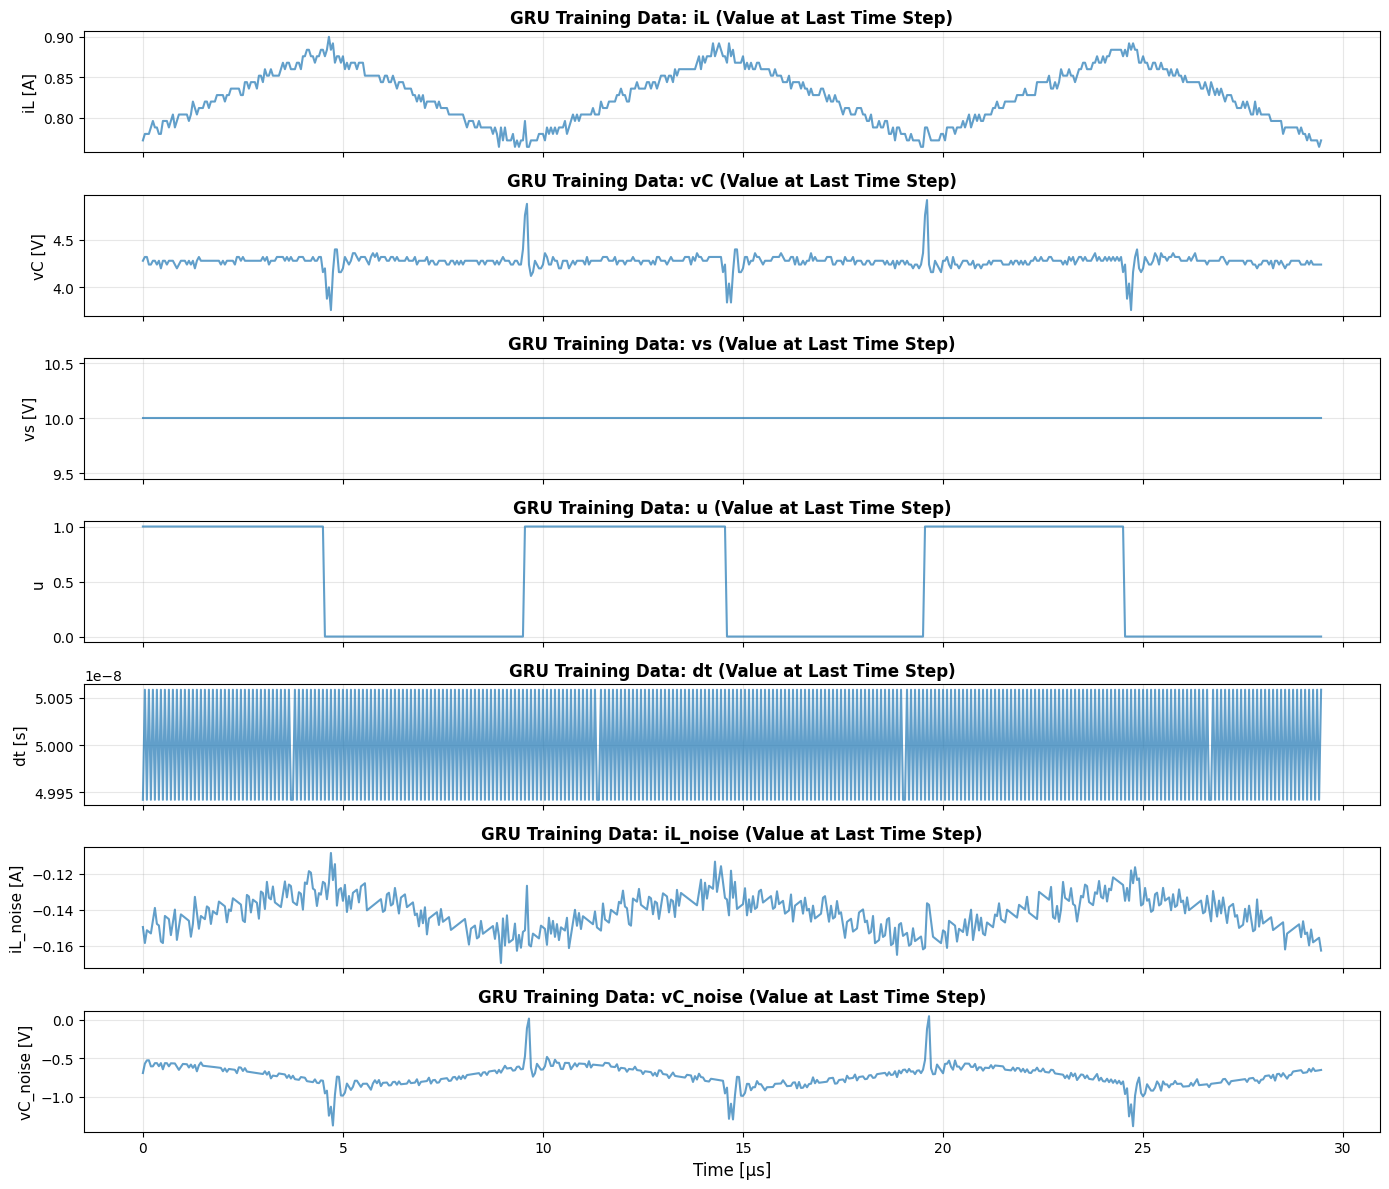

In [21]:
# 学習データ
X_train_seq_np: np.ndarray = X_train_seq.detach().cpu().numpy()
y_train_seq_np: np.ndarray = y_train_seq.detach().cpu().numpy()

# 入力特徴量名と単位
feature_names: list[str] = ["iL", "vC", "vs", "u", "dt", "iL_noise", "vC_noise"]
feature_units: list[str] = ["[A]", "[V]", "[V]", "", "[s]", "[A]", "[V]"]


fig, axs = plt.subplots(7, 1, figsize=(14, 12), sharex=True)

last_timestep_features: np.ndarray = X_train_seq_np[:, -1, :]  # [N, 7]

# time_axisをt_train（μs単位）に
time_axis: np.ndarray = t_train[: X_train_seq_np.shape[0]] * 1e6  # μs

for i in range(7):
    axs[i].plot(time_axis, last_timestep_features[:, i], linewidth=1.5, alpha=0.7)
    axs[i].set_ylabel(f"{feature_names[i]} {feature_units[i]}", fontsize=11)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(
        f"GRU Training Data: {feature_names[i]} (Value at Last Time Step)",
        fontsize=12,
        fontweight="bold",
    )

axs[6].set_xlabel("Time [μs]", fontsize=12)
plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig,
        "gru_training_data_features",
        result_dir,
        "GRU 学習データ",
    )


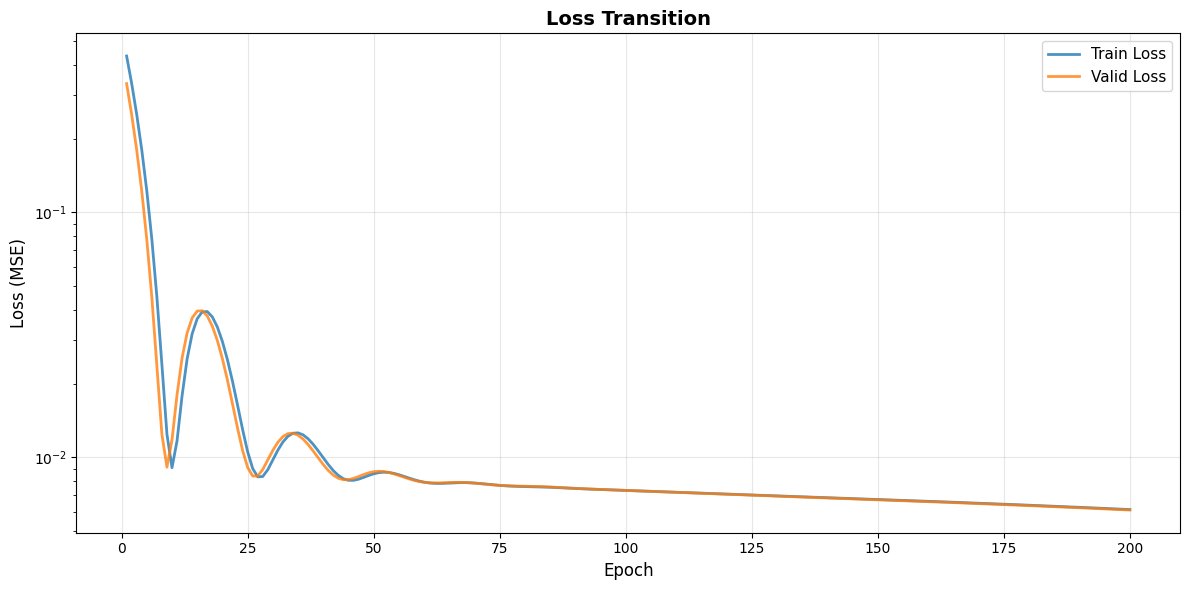

In [22]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, gru_epochs + 1)
ax.plot(
    epochs_list, gru_loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8
)
ax.plot(
    epochs_list, gru_loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8
)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# 画像をログに保存
if keep_log:
    save_figure_to_log(fig, "gru_loss_transition", result_dir, "GRU Lossの遷移")


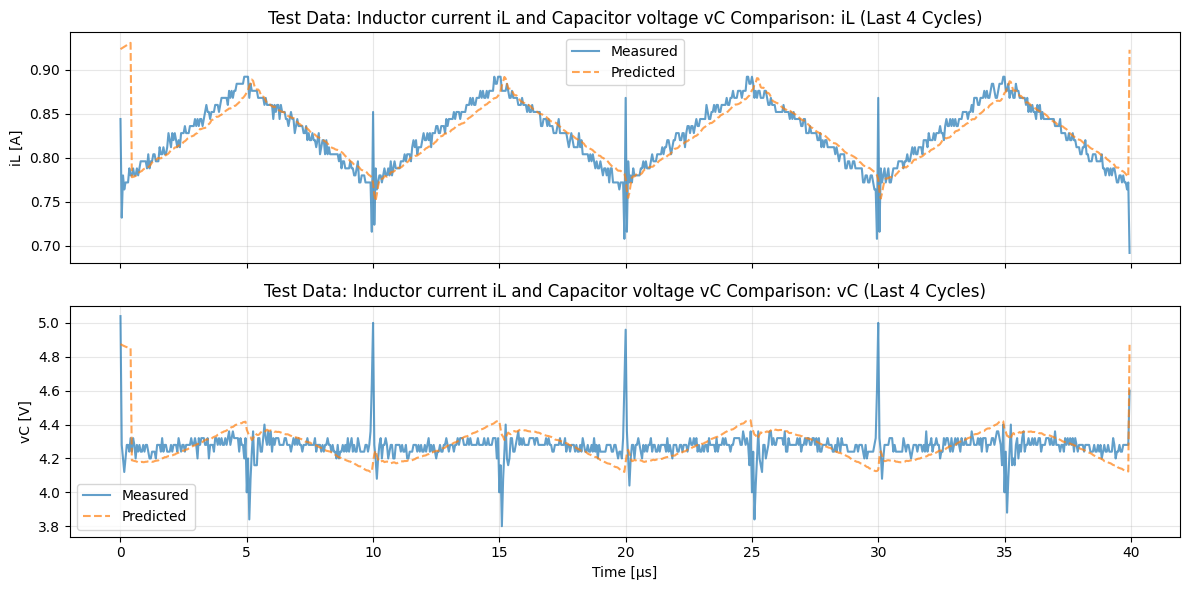

In [23]:
# テストデータでの予測
# 前処理
t_sim: np.ndarray = np.linspace(0, 1000 * T, 1000 * samples_per_cycle + 1)

t_additional = t_downsampled + t_sim[-1]
t_sim = np.concatenate([t_sim, t_additional])

dt_sim: np.ndarray = np.diff(t_sim)

# スイッチング信号
duty_phase = (t_sim[:-1] % T) / T
u_sim = (duty_phase < duty).astype(int)

# 入力電圧
vs_sim = np.ones(len(t_sim) - 1) * Vin

x_tensor = torch.tensor(np.c_[vs_sim, u_sim, dt_sim], dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)
    il_list.append(h_current[0, 0].item())  # i_L
    vc_list.append(h_current[0, 1].item())  # v_C

    for j in range(len(t_sim) - 1):
        h_current = buck_converter_cell(h_current, x_tensor[j : j + 1])

        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

iL_buck_pred = torch.tensor(np.array(il_list[-len(t_test) :]), dtype=torch.float32)
vC_buck_pred = torch.tensor(np.array(vc_list[-len(t_test) :]), dtype=torch.float32)

# GRUでノイズを予測
with torch.no_grad():
    gru_model.eval()
    noise_pred = gru_model(X_test_seq)  # [batch_size, 2] = [iL_noise, vC_noise]

# 時間軸で累積
iL_noise_cumulative = torch.zeros(len(iL_buck_pred))
vC_noise_cumulative = torch.zeros(len(vC_buck_pred))

# 最初のseq_length点は0
for i in range(len(noise_pred)):
    idx = i + seq_length
    if idx < len(iL_noise_cumulative):
        iL_noise_cumulative[idx] = noise_pred[i, 0]
        vC_noise_cumulative[idx] = noise_pred[i, 1]

# BuckConverterCellの予測とGRUのノイズ予測を足し合わせる
iL_combined = iL_buck_pred + iL_noise_cumulative
vC_combined = vC_buck_pred + vC_noise_cumulative

# 実機データのテスト箇所を抽出
t_test_start = t_test[0]
t_test_end = t_test[-1]

mask_test = (t_downsampled >= t_test_start) & (t_downsampled <= t_test_end)
t_test_actual = t_downsampled[mask_test]
iL_test_actual = iL_downsampled[mask_test]
vC_test_actual = vC_downsampled[mask_test]

# 短い方に合わせる
min_len = min(len(t_test_actual), len(iL_combined))
t_test_actual = t_test_actual[:min_len]
iL_test_actual = iL_test_actual[:min_len]
vC_test_actual = vC_test_actual[:min_len]

# GRU出力（ノイズ）も同じ長さに揃える
iL_noise_cumulative = iL_noise_cumulative[:min_len]
vC_noise_cumulative = vC_noise_cumulative[:min_len]

iL_combined = iL_combined[:min_len]
vC_combined = vC_combined[:min_len]
iL_buck_pred = iL_buck_pred[:min_len]
vC_buck_pred = vC_buck_pred[:min_len]


fig, ax = plot_compare_tail(
    t_test_actual,
    iL_test_actual,
    vC_test_actual,
    "Measured",
    t_test_actual,
    iL_combined,
    vC_combined,
    "Predicted",
    T,
    N_cycles=4,
    title="Test Data: Inductor current iL and Capacitor voltage vC Comparison",
)

if keep_log:
    save_figure_to_log(
        fig,
        "buck_gru_combined_comparison",
        result_dir,
        "BuckConverterCell + GRU の推論結果",
    )


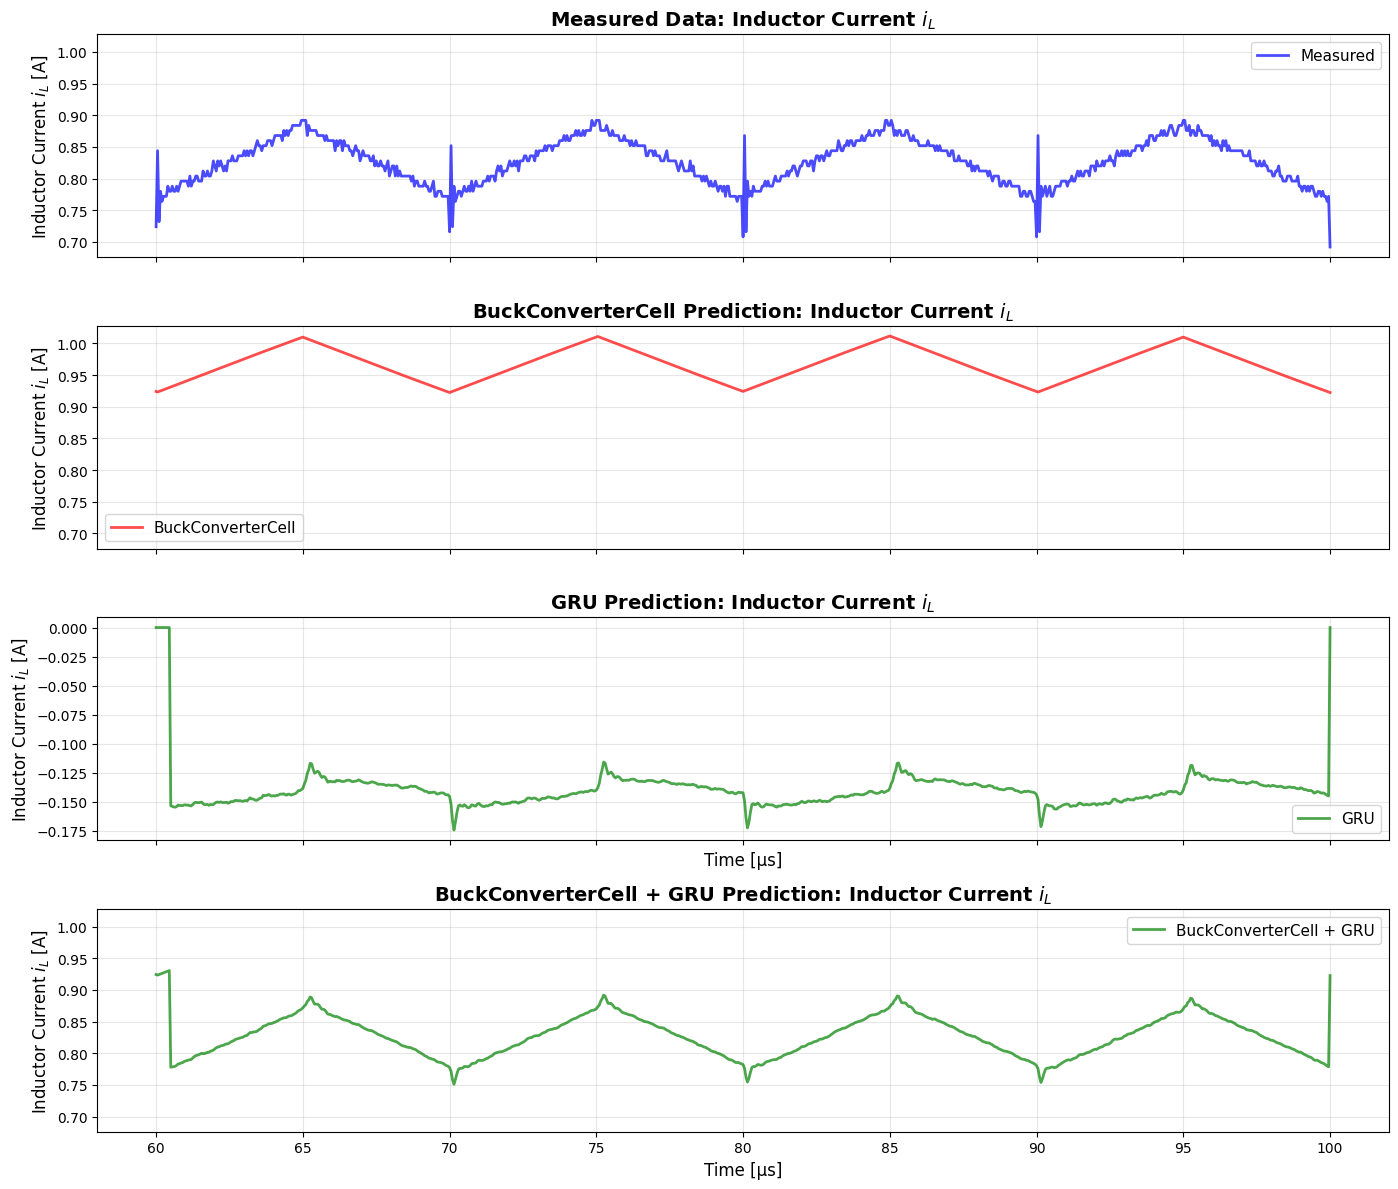

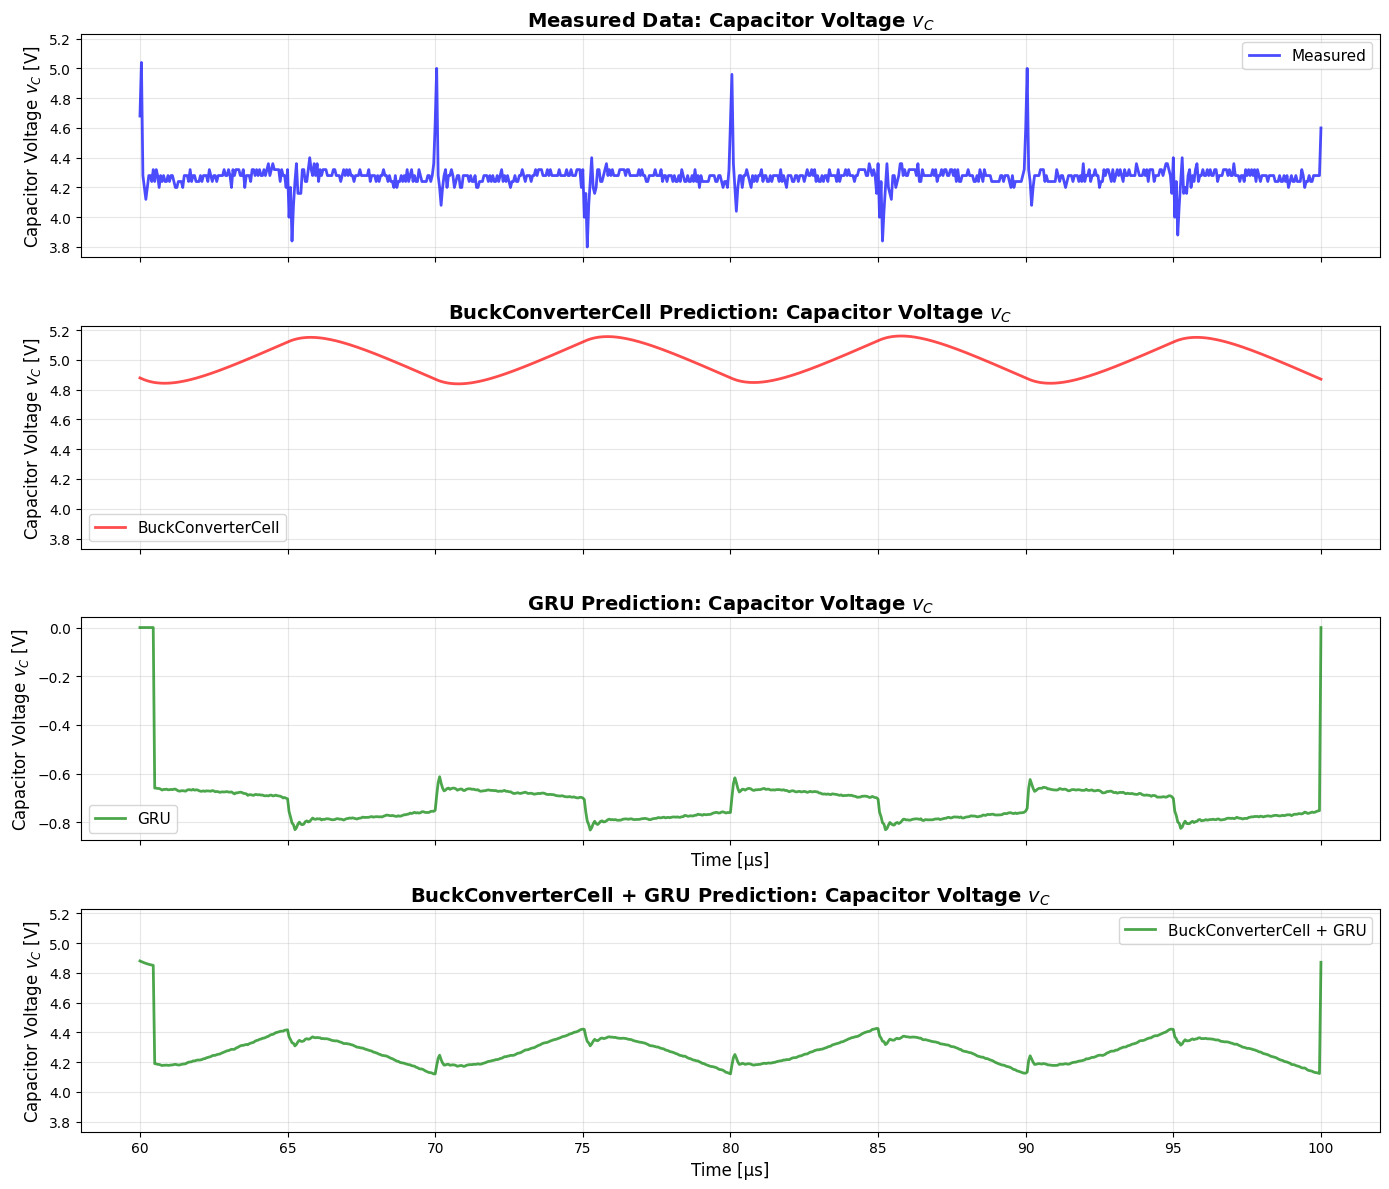

In [24]:
iL_min = min(iL_test_actual.min(), iL_buck_pred.min().item(), iL_combined.min().item())
iL_max = max(iL_test_actual.max(), iL_buck_pred.max().item(), iL_combined.max().item())
iL_range = iL_max - iL_min
iL_ylim = (iL_min - iL_range * 0.05, iL_max + iL_range * 0.05)  # 5% margin

vC_min = min(vC_test_actual.min(), vC_buck_pred.min().item(), vC_combined.min().item())
vC_max = max(vC_test_actual.max(), vC_buck_pred.max().item(), vC_combined.max().item())
vC_range = vC_max - vC_min
vC_ylim = (vC_min - vC_range * 0.05, vC_max + vC_range * 0.05)  # 5% margin

# プロット iL
fig_iL, axs_iL = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Measured iL
axs_iL[0].plot(
    t_test_actual * 1e6,
    iL_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs_iL[0].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[0].set_title(
    "Measured Data: Inductor Current $i_L$", fontsize=14, fontweight="bold"
)
axs_iL[0].set_ylim(iL_ylim)
axs_iL[0].grid(True, alpha=0.3)
axs_iL[0].legend(fontsize=11)

# BuckConverterCell iL
axs_iL[1].plot(
    t_test_actual * 1e6,
    iL_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
)
axs_iL[1].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[1].set_title(
    "BuckConverterCell Prediction: Inductor Current $i_L$",
    fontsize=14,
    fontweight="bold",
)
axs_iL[1].set_ylim(iL_ylim)
axs_iL[1].grid(True, alpha=0.3)
axs_iL[1].legend(fontsize=11)

# GRU iL
axs_iL[2].plot(
    t_test_actual * 1e6,
    iL_noise_cumulative,
    label="GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_iL[2].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[2].set_xlabel("Time [μs]", fontsize=12)
axs_iL[2].set_title(
    "GRU Prediction: Inductor Current $i_L$",
    fontsize=14,
    fontweight="bold",
)
# axs_iL[2].set_ylim(iL_ylim)
axs_iL[2].grid(True, alpha=0.3)
axs_iL[2].legend(fontsize=11)


# BuckConverterCell + GRU iL
axs_iL[3].plot(
    t_test_actual * 1e6,
    iL_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_iL[3].set_ylabel("Inductor Current $i_L$ [A]", fontsize=12)
axs_iL[3].set_xlabel("Time [μs]", fontsize=12)
axs_iL[3].set_title(
    "BuckConverterCell + GRU Prediction: Inductor Current $i_L$",
    fontsize=14,
    fontweight="bold",
)
axs_iL[3].set_ylim(iL_ylim)
axs_iL[3].grid(True, alpha=0.3)
axs_iL[3].legend(fontsize=11)

plt.tight_layout()
plt.show()

# vC comparison - separate subplots
fig_vC, axs_vC = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Measured vC
axs_vC[0].plot(
    t_test_actual * 1e6,
    vC_test_actual,
    label="Measured",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs_vC[0].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[0].set_title(
    "Measured Data: Capacitor Voltage $v_C$", fontsize=14, fontweight="bold"
)
axs_vC[0].set_ylim(vC_ylim)
axs_vC[0].grid(True, alpha=0.3)
axs_vC[0].legend(fontsize=11)

# BuckConverterCell vC
axs_vC[1].plot(
    t_test_actual * 1e6,
    vC_buck_pred,
    label="BuckConverterCell",
    linewidth=2,
    alpha=0.7,
    color="red",
)
axs_vC[1].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[1].set_title(
    "BuckConverterCell Prediction: Capacitor Voltage $v_C$",
    fontsize=14,
    fontweight="bold",
)
axs_vC[1].set_ylim(vC_ylim)
axs_vC[1].grid(True, alpha=0.3)
axs_vC[1].legend(fontsize=11)

# GRU vC
axs_vC[2].plot(
    t_test_actual * 1e6,
    vC_noise_cumulative,
    label="GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_vC[2].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[2].set_xlabel("Time [μs]", fontsize=12)
axs_vC[2].set_title(
    "GRU Prediction: Capacitor Voltage $v_C$",
    fontsize=14,
    fontweight="bold",
)
# axs_vC[2].set_ylim(vC_ylim)
axs_vC[2].grid(True, alpha=0.3)
axs_vC[2].legend(fontsize=11)

# BuckConverterCell + GRU vC
axs_vC[3].plot(
    t_test_actual * 1e6,
    vC_combined,
    label="BuckConverterCell + GRU",
    linewidth=2,
    alpha=0.7,
    color="green",
)
axs_vC[3].set_ylabel("Capacitor Voltage $v_C$ [V]", fontsize=12)
axs_vC[3].set_xlabel("Time [μs]", fontsize=12)
axs_vC[3].set_title(
    "BuckConverterCell + GRU Prediction: Capacitor Voltage $v_C$",
    fontsize=14,
    fontweight="bold",
)
axs_vC[3].set_ylim(vC_ylim)
axs_vC[3].grid(True, alpha=0.3)
axs_vC[3].legend(fontsize=11)

plt.tight_layout()
plt.show()

if keep_log:
    save_figure_to_log(
        fig_iL,
        "buck_gru_combined_iL_separate",
        result_dir,
        "インダクタ電流 $i_L$ の推論結果 (GRUの出力だけy軸をずらしている)",
    )
    save_figure_to_log(
        fig_vC,
        "buck_gru_combined_vC_separate",
        result_dir,
        "コンデンサ電圧 $v_C$ の推論結果 (GRUの出力だけy軸をずらしている)",
    )